# Demo Burgers with RBF Kernel

## Import

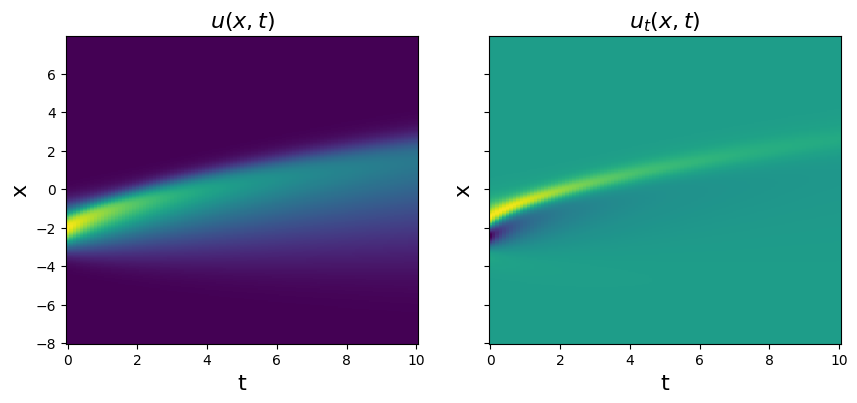

In [1]:
import numpy as np
import sys
sys.path.append('..')
from data.smoothing import smooth_berg, smooth_pend_rbf
from data.burgers_eqn import u, u_t,  t, x
from utils.normalize import normalize_pend
from data.pde_recovery import sample_idxs, load_and_shift_pend_data, optimal_recovery, rbf_vector_kernel, cross_validation, rhs, mse_loss, cross_validation_lengthscale, cross_validation_nugget
from scipy.linalg import cho_factor, cho_solve
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import pysindy as ps
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split

In [2]:

u = u[:,:,0]

In [3]:
u, u_test, x, x_test = train_test_split(u, x)

In [4]:
u.shape

(192, 101)

In [5]:
x.shape

(192,)

In [6]:
x_test

array([ 1.9375, -0.625 , -5.5625, -1.25  ,  1.1875,  6.5   , -7.5625,
        5.375 , -3.125 , -0.125 ,  7.    , -5.6875,  3.75  , -0.9375,
       -1.4375,  7.5   , -5.4375, -6.125 , -1.75  , -5.3125,  7.125 ,
       -2.1875, -3.1875,  3.125 , -4.3125,  4.0625, -5.1875, -4.5625,
        0.    , -5.375 ,  6.5625,  0.875 , -1.5625, -3.8125, -1.1875,
       -6.8125, -5.0625,  1.5625,  5.0625, -3.375 , -3.4375, -0.25  ,
        4.5625, -3.6875, -6.5   ,  6.25  , -6.5625,  2.75  , -7.75  ,
       -0.875 , -5.875 , -2.375 ,  4.6875,  0.375 , -7.1875,  4.1875,
        5.1875,  0.1875,  5.4375, -4.75  ,  3.0625, -6.1875,  3.9375,
       -5.75  ])

In [7]:
idx_sort = x.argsort()
u = u[idx_sort[::-1],:]
x = sorted(x)

## Parameter search smoothing

In [8]:
l = np.linspace(1e-8, 4, 20)
lam = np.linspace(1e-6, 3, 20)

In [9]:
# sample_t = np.sort(np.random.randint(0, 101, 101))
# sample_x = np.sort(np.random.randint(0,256, ))
xx, tt = np.meshgrid(x, t)
points = np.array([np.array([xx.flatten()[i], tt.flatten()[i]]) for i in range(len(x)*len(t))])
xx.shape
tt.shape
rmse = mean_squared_error(u[:,:], np.zeros(u[:,:].shape), squared=False)
# add 20% noise (note the impact on derivatives depends on step size...)

u_flat = (u + np.random.normal(0, rmse / 50.0, u.shape)).flatten()
points = points

In [10]:
(u + np.random.normal(0, rmse / 5.0, u.shape))[:, :10].shape

(192, 10)

In [11]:
(u + np.random.normal(0, rmse / 50.0, u.shape))[:, :10].shape

(192, 10)

In [12]:
best_mse = 1000
for i in l:
    for j in lam:
        S1, S2 =smooth_pend_rbf(t, (u + np.random.normal(0, rmse / 5.0, u.shape))[0:10, :], (u + np.random.normal(0, rmse / 50.0, u.shape))[0:10, :], l=i, lam = j)
        mse = np.linalg.norm(u[0:10, :]- np.array(S1)[:,:10,0].T) / 20
        if mse < best_mse:
            best_mse = mse
            best_params = [i,j]

In [13]:
# 3.7894736847368424, 0.2
print(best_mse)
print(best_params)

0.007103851327938694
[4.0, 2.3684212631578947]


## Smooth data

In [14]:
xx, tt = np.meshgrid(x, t)
points = np.array([np.array([xx.flatten()[i], tt.flatten()[i]]) for i in range(len(x)*len(t))])
xx.shape
tt.shape
rmse = mean_squared_error(u[:,:], np.zeros(u[:,:].shape), squared=False)
# add 20% noise (note the impact on derivatives depends on step size...)

In [15]:
# 3.7894736847368424, 0.2
# S = smooth_berg(points, u_flat.reshape(1, len(u_flat)), 0.2105263247368421, 0.10526315789563159)
S1, S2 = smooth_pend_rbf(t, (u + np.random.normal(0, rmse / 5.0, u.shape)), (u + np.random.normal(0, rmse / 20.0, u.shape)), 3.7894736847368424, 0.2)

In [16]:
np.array(S1).shape

(101, 192, 5)

In [17]:
u.shape

(192, 101)

Text(0.5, 1.0, 'Noisy $u(x, t)$')

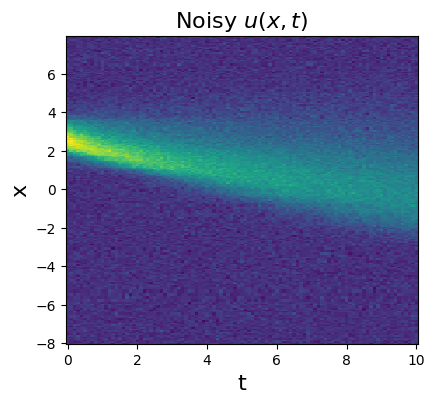

In [18]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, x, (u + np.random.normal(0, rmse / 5.0, u.shape)))
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'Noisy $u(x, t)$', fontsize=16)

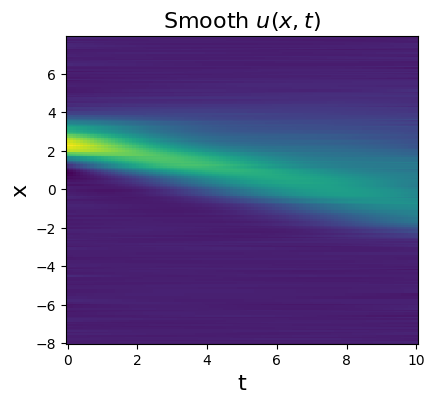

In [19]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, x, np.array(S1)[:,:,0].T)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'Smooth $u(x, t)$', fontsize=16)
plt.show()

Text(0.5, 0.5, 'x')

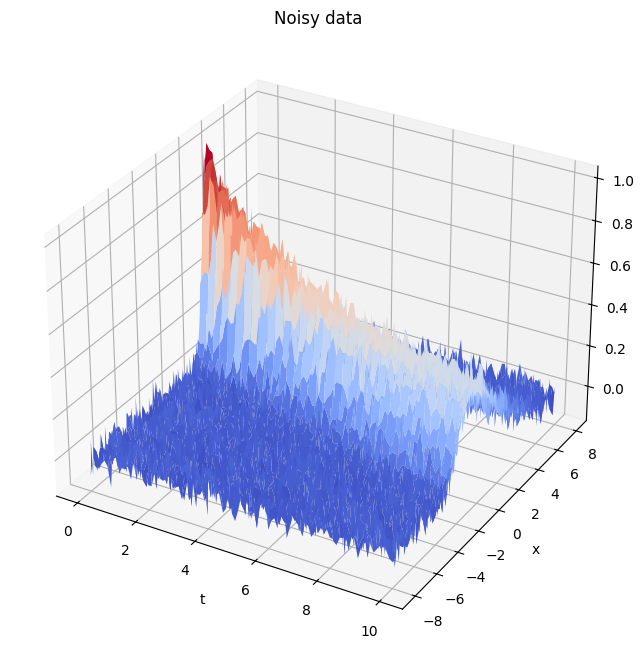

In [20]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
u_surf=ax.plot_surface(tt, xx, (u + np.random.normal(0, rmse / 5.0, u.shape)).T, cmap=plt.cm.coolwarm)
plt.title("Noisy data")
plt.xlabel('t')
plt.ylabel('x')

Text(0.5, 0.5, 'x')

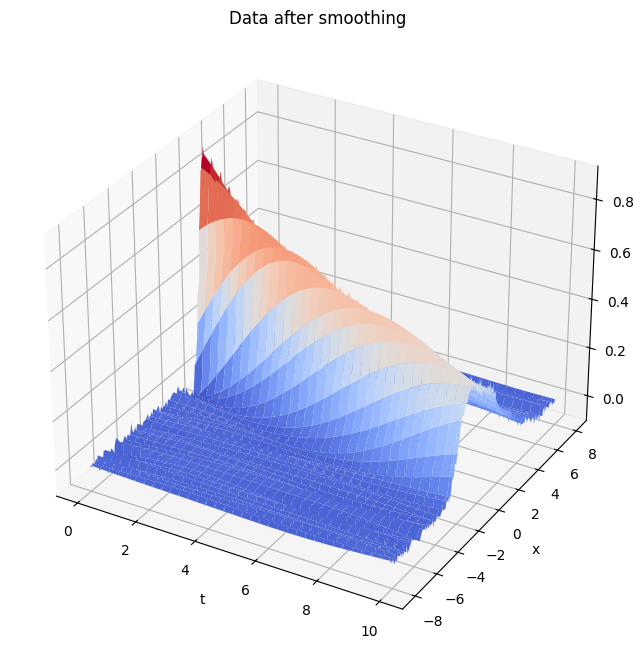

In [21]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
u_surf=ax.plot_surface(tt, xx, np.array(S1)[:,:,0], cmap=plt.cm.coolwarm)
plt.title("Data after smoothing")
plt.xlabel('t')
plt.ylabel('x')

Text(0.5, 0.5, 'x')

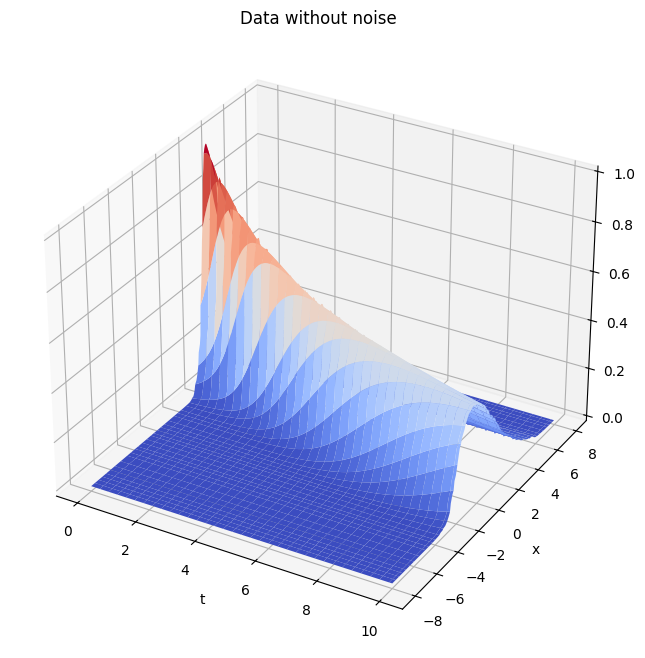

In [22]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
u_surf=ax.plot_surface(tt, xx, u.T, cmap=plt.cm.coolwarm)
plt.title("Data without noise")
plt.xlabel('t')
plt.ylabel('x')

### Taking the derivatives of the smooth data

In [23]:
u_hat = np.array(S1)[:,:,0]
u_hat.shape

(101, 192)

In [24]:
import pysindy as ps
dt = t[1] - t[0]
dx = x[1] - x[0]
print(dt, " ", dx)
u_t_hat = ps.FiniteDifference(axis=0)._differentiate(u_hat, t=dt)
u_x_hat = ps.FiniteDifference(axis=1)._differentiate(u_hat, t=dx)
u_xx_hat = ps.FiniteDifference(axis=1)._differentiate(u_x_hat, t=dx)

0.1   0.0625


In [25]:
u_t = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)

In [26]:
u_t = minmax_scale(ps.FiniteDifference(axis=1)._differentiate(u, t=dt))
u_t_hat = minmax_scale(u_t_hat.T).T
u_x_hat = minmax_scale(u_x_hat.T).T
u_xx_hat = minmax_scale(u_xx_hat.T).T
u_xx_hat.shape

(101, 192)

Text(0.5, 0.5, 'x')

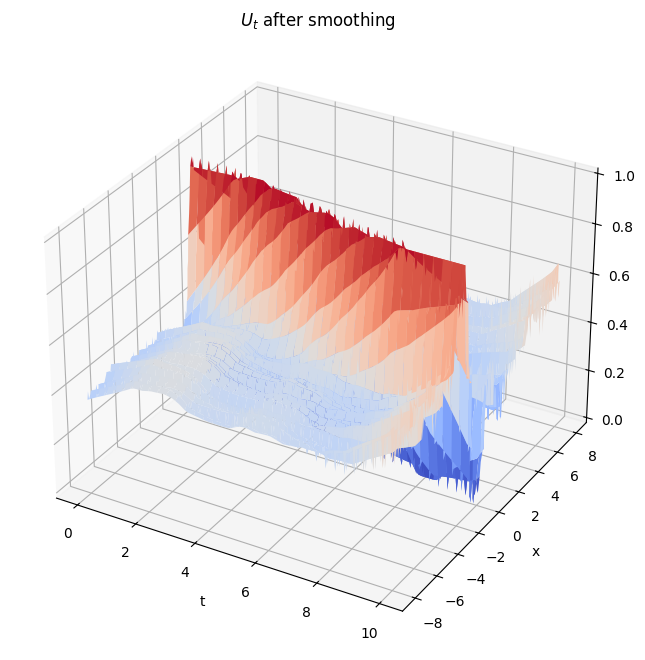

In [27]:

  
# importing required libraries 
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
u_surf=ax.plot_surface(tt, xx, u_t_hat, cmap=plt.cm.coolwarm)
plt.title("$U_t$ after smoothing")
plt.xlabel('t')
plt.ylabel('x')

Text(0.5, 0.5, 'x')

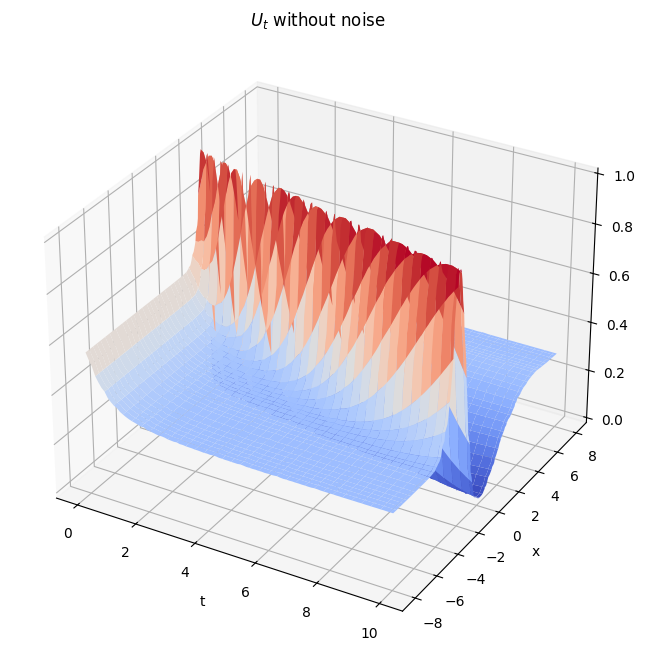

In [28]:

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
u_surf=ax.plot_surface(tt, xx, u_t.T, cmap=plt.cm.coolwarm)
plt.title("$U_t$ without noise")
plt.xlabel('t')
plt.ylabel('x')

In [29]:
mean_squared_error(u_t.T, u_t_hat)

0.028736372452304423

In [30]:
mean_squared_error(u.T, u_hat)

0.00043079434615260286

In [31]:
u_hat.shape

(101, 192)

In [32]:
u_x_hat.shape

(101, 192)

In [33]:
u_xx_hat.shape

(101, 192)

## Crossvalidation for PDE discovery

In [34]:
lengthscale_values_u2 = np.linspace(0.1,15, 50) # Chosen based on preliminary result of .1 (and subsequently .01) being best for a coarse search
nugget_values_u2 = np.linspace(1e-6, 2, 10)
mse_surface_u2 = cross_validation(np.array([u_hat, u_x_hat, u_xx_hat]).reshape((101,3,len(x))).T, np.array([u_t_hat]).reshape((101,len(x))), lengthscale_values_u2, nugget_values_u2, num_folds = 3)

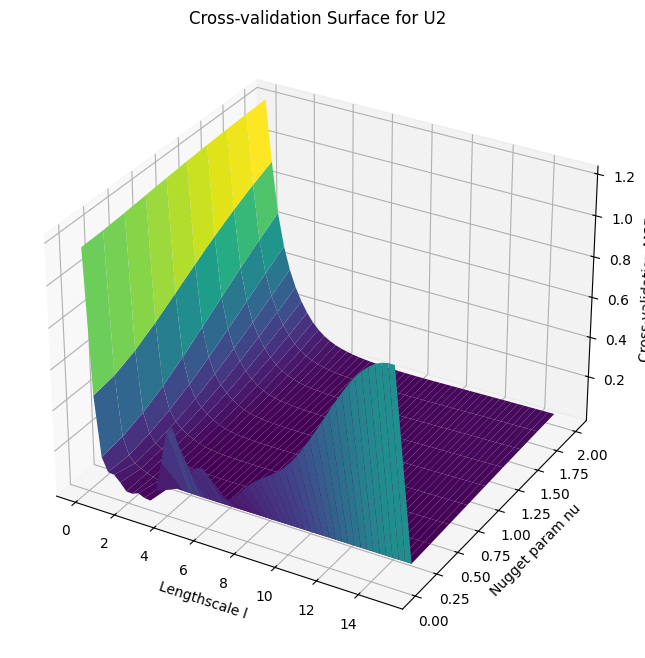

Indices of the minimum value: (19, 1)
l minimum value: 5.877551020408163
nu minimum value: 0.22222311111111112
Minimum value: 0.0006544855343022971


In [35]:
# Plot cross-validation surface
L1, L2 = np.meshgrid(lengthscale_values_u2, nugget_values_u2)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(L1, L2, mse_surface_u2.T, cmap='viridis')
ax.set_xlabel('Lengthscale l')
ax.set_ylabel('Nugget param nu')
ax.set_zlabel('Cross-validation MSE')
ax.set_title('Cross-validation Surface for U2')
plt.show()

min_index_u2 = np.unravel_index(np.argmin(mse_surface_u2), mse_surface_u2.shape)

print("Indices of the minimum value:", min_index_u2)
print("l minimum value:", lengthscale_values_u2[min_index_u2[0]])
print("nu minimum value:", nugget_values_u2[min_index_u2[1]])
print("Minimum value:", mse_surface_u2[min_index_u2])

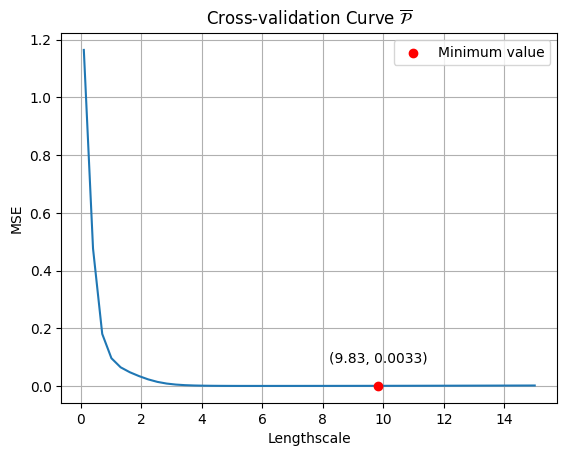

In [36]:
plt.title("Cross-validation Curve $\overline{\mathcal{P}}$")
plt.plot(lengthscale_values_u2, mse_surface_u2[:,1])
plt.xlabel("Lengthscale")
plt.ylabel("MSE")
plt.grid()
plt.scatter(9.83, 0.001, color='red', zorder=5, label='Minimum value')
plt.legend()
plt.text(9.83, 0.07, '(9.83, 0.0033)', fontsize=10, verticalalignment='bottom', horizontalalignment='center')
plt.show()

In [37]:
P_hat_train = optimal_recovery(np.array([u_hat, u_x_hat, u_xx_hat]).reshape((101,3,len(x))), np.array([u_t_hat]).reshape((101,len(x))).T, np.array([u_hat, u_x_hat, u_xx_hat]).reshape((101,3,len(x))),lengthscale_values_u2[min_index_u2[0]], nugget_values_u2[min_index_u2[1]])

Text(0.5, 0.5, 'x')

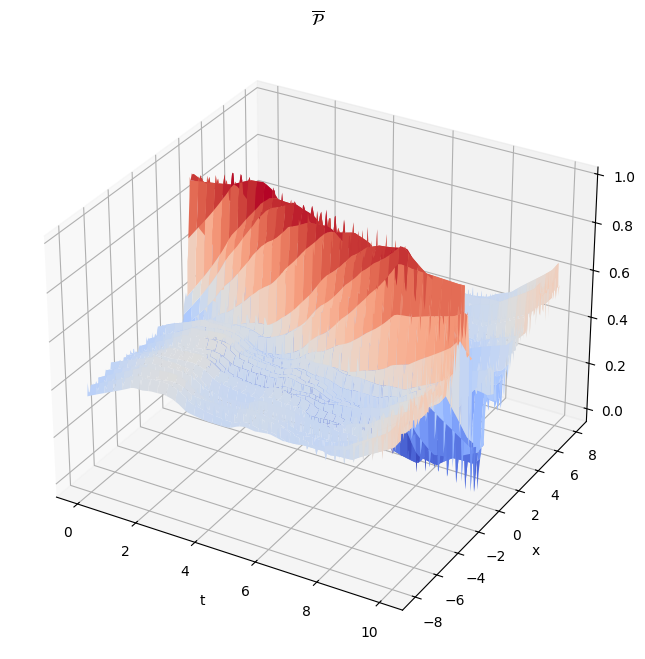

In [38]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
u_surf=ax.plot_surface(tt, xx, P_hat_train.T, cmap=plt.cm.coolwarm)
plt.title("$\overline{\mathcal{P}}$")
plt.xlabel('t')
plt.ylabel('x')

Text(0.5, 0.5, 'x')

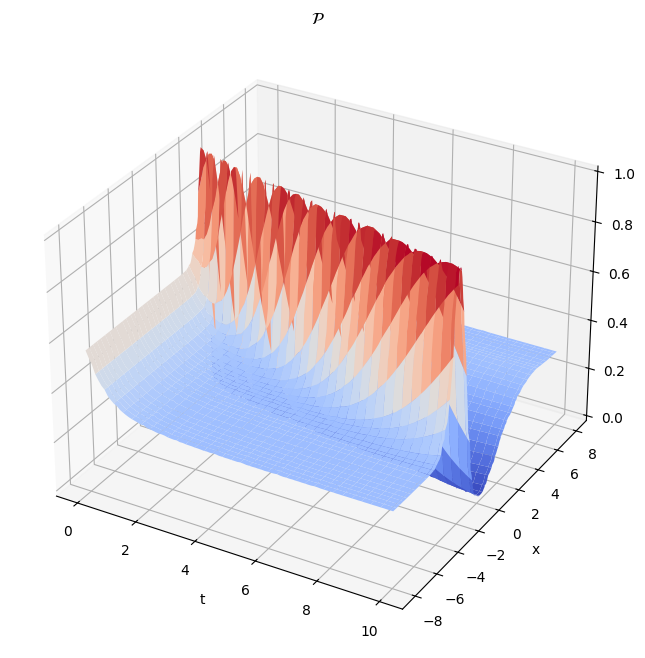

In [39]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
u_surf=ax.plot_surface(tt, xx, u_t.T, cmap=plt.cm.coolwarm)
plt.title("$\mathcal{P}$")
plt.xlabel('t')
plt.ylabel('x')

In [40]:
mean_squared_error(P_hat_train, u_t)

0.029386330625759793

## Generate test data and test method

In [41]:
idx_sort = x_test.argsort()
u_test = u_test[idx_sort[::-1],:]
x_test = sorted(x_test)

In [42]:
tt,xx = np.meshgrid(t,x_test)

In [43]:
# 3.7894736847368424, 0.2
S1, S2 = smooth_pend_rbf(t, (u_test + np.random.normal(0, rmse / 5.0, u_test.shape) + 0.1 * np.sin(tt)), (u + np.random.normal(0, rmse / 20.0, u.shape)), 3.7894736847368424, 0.2)

In [44]:
np.random.normal(0, rmse / 5.0, u_test.shape).shape

(64, 101)

In [45]:
u_test.shape

(64, 101)

In [46]:
(0.1*np.sin(tt)).shape

(64, 101)

Text(0.5, 1.0, 'Noisy $u(x, t)$')

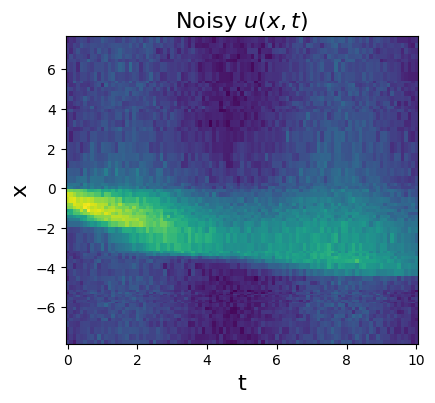

In [47]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, x_test, (u_test + np.random.normal(0, rmse / 5.0, u_test.shape) + 0.1*np.sin(tt)))
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'Noisy $u(x, t)$', fontsize=16)

Text(0.5, 1.0, '$u(x, t)$ After Smoothing')

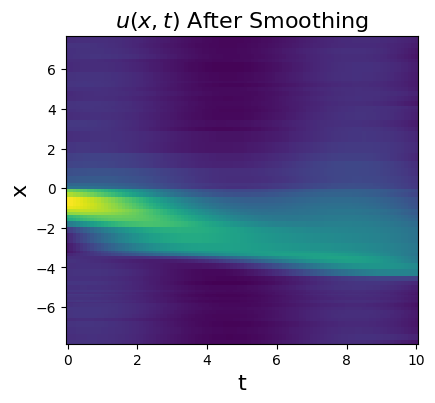

In [48]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, x_test, np.array(S1)[:,:,0].T)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$ After Smoothing', fontsize=16)

Text(0.5, 0.5, 'x')

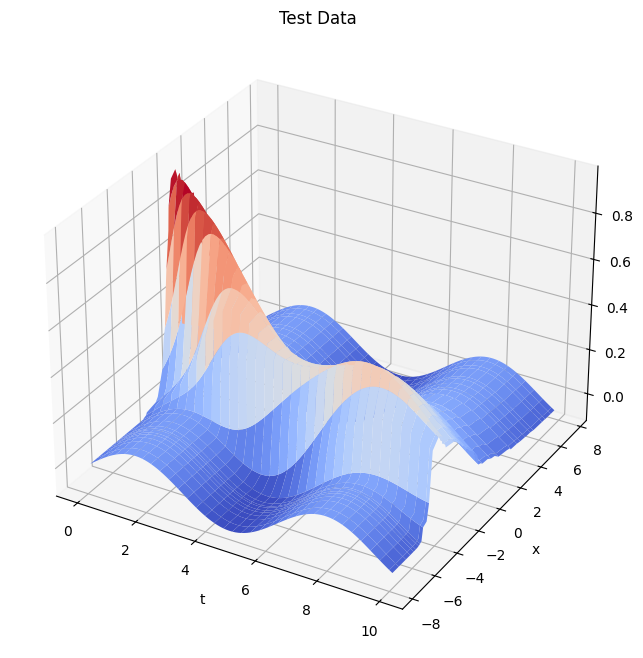

In [49]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
u_surf=ax.plot_surface(tt, xx, u_test+ 0.1 * np.sin(tt), cmap=plt.cm.coolwarm)
plt.title("Test Data")
plt.xlabel('t')
plt.ylabel('x')

Text(0.5, 0.5, 'x')

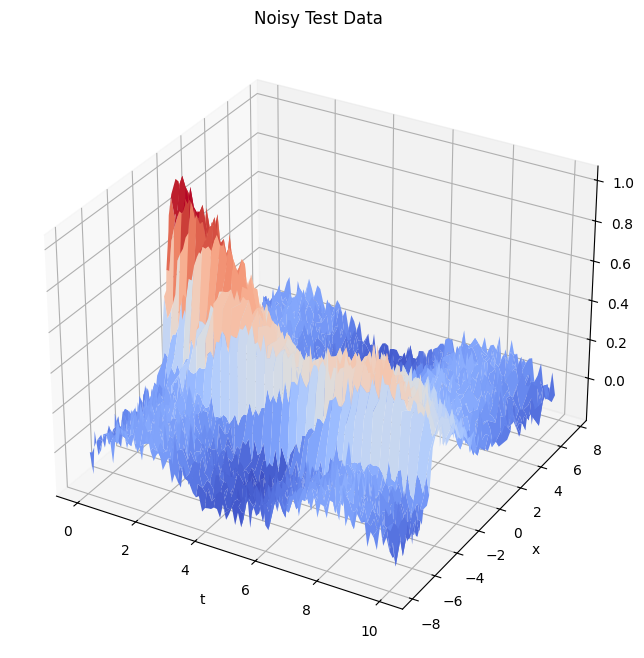

In [50]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
u_surf=ax.plot_surface(tt, xx, (u_test + np.random.normal(0, rmse / 5.0, u_test.shape) + 0.1*np.sin(tt)), cmap=plt.cm.coolwarm)
plt.title("Noisy Test Data")
plt.xlabel('t')
plt.ylabel('x')

In [51]:
np.array(S1).shape

(101, 64, 5)

Text(0.5, 0.5, 'x')

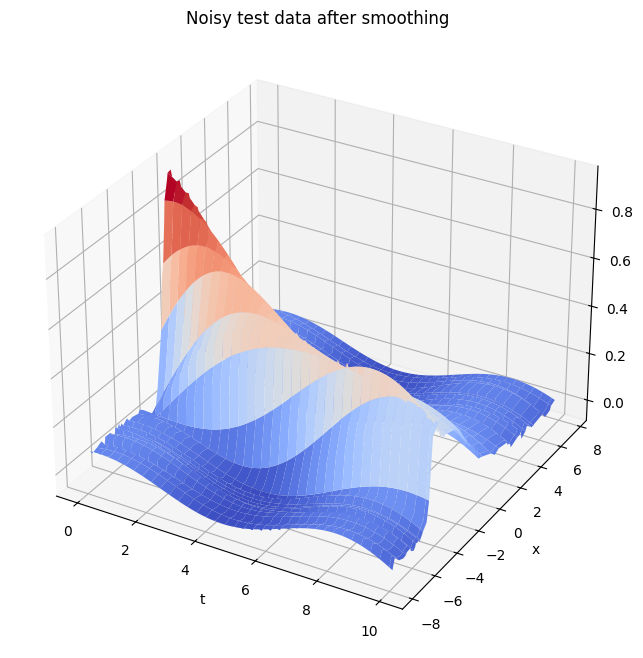

In [52]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
u_surf=ax.plot_surface(tt, xx, np.array(S1)[:,:,0].T, cmap=plt.cm.coolwarm)
plt.title("Noisy test data after smoothing")
plt.xlabel('t')
plt.ylabel('x')

In [53]:

dt = t[1] - t[0]
dx = x_test[1] - x_test[0]
print(dt, " ", dx)
u_hat_test = np.array(S1)[:,:,0]
u_t_test = ps.FiniteDifference(axis=0)._differentiate(u_test, t=dt)
u_x_hat_test = ps.FiniteDifference(axis=1)._differentiate(u_hat_test, t=dx)
u_xx_hat_test = ps.FiniteDifference(axis=1)._differentiate(u_x_hat_test, t=dx)
u_xx_hat_test.shape

0.1   0.1875


(101, 64)

In [54]:
u_t_test = minmax_scale(ps.FiniteDifference(axis=1)._differentiate(u_test, t=dt))
u_hat_test = minmax_scale(u_hat_test.T).T
u_x_hat_test = minmax_scale(u_x_hat_test.T).T
u_xx_hat_test = minmax_scale(u_xx_hat_test.T).T
u_xx_hat.shape

(101, 192)

In [55]:
u_hat_test.shape

(101, 64)

Text(0.5, 0.5, 'x')

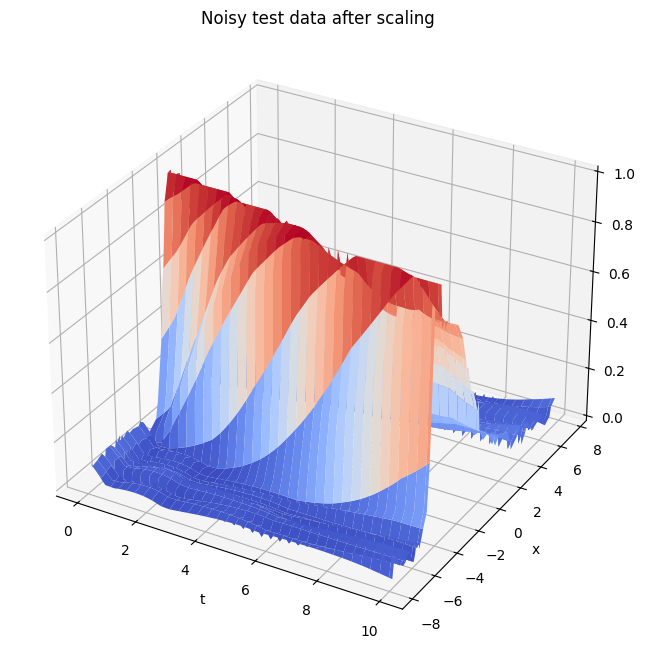

In [56]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
u_surf=ax.plot_surface(tt, xx, u_hat_test.T, cmap=plt.cm.coolwarm)
plt.title("Noisy test data after scaling")
plt.xlabel('t')
plt.ylabel('x')

In [57]:
np.array([u_hat, u_x_hat, u_xx_hat]).shape

(3, 101, 192)

In [58]:
P_hat_test = optimal_recovery(np.array([u_hat, u_x_hat, u_xx_hat]).reshape((101,3,192)), np.array([u_t_hat]).reshape((101,192)).T, np.array([u_hat_test, u_x_hat_test, u_xx_hat_test]).reshape((101,3,len(x_test))),lengthscale_values_u2[min_index_u2[0]], nugget_values_u2[min_index_u2[1]])


In [59]:
P_hat_test.shape

(64, 101)

Text(0.5, 1.0, 'Recovered $\\overline{\\mathcal{P}}$')

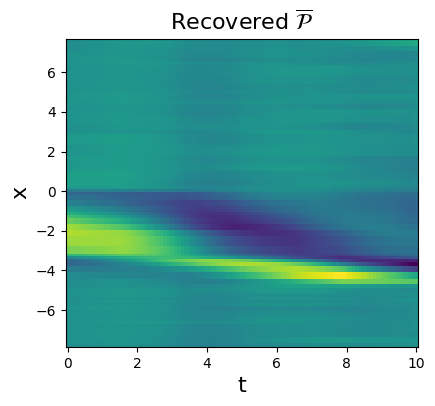

In [60]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, x_test, P_hat_test)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'Recovered $\overline{\mathcal{P}}$', fontsize=16)

Text(0.5, 1.0, 'True $\\mathcal{P}$')

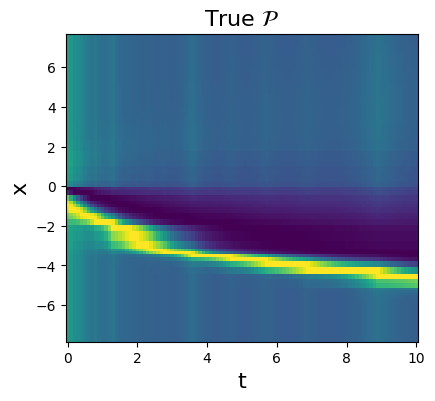

In [61]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, x_test, u_t_test)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'True $\mathcal{P}$', fontsize=16)

Text(0.5, 0.5, 'x')

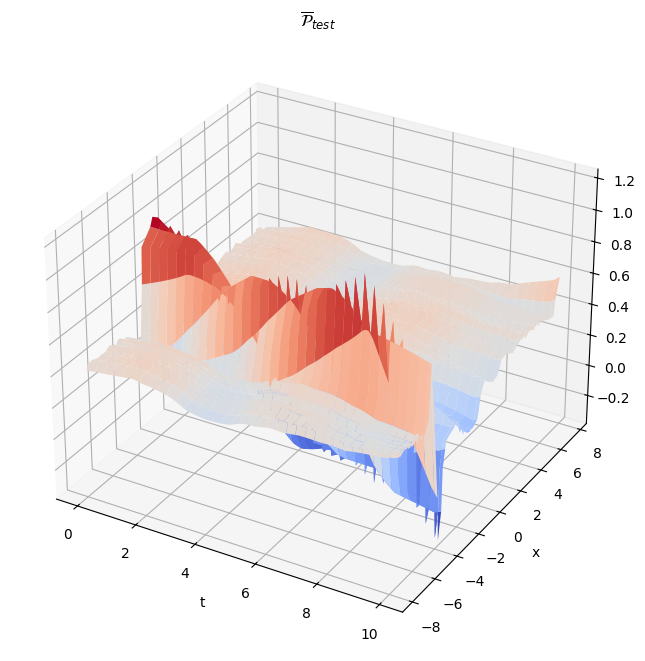

In [62]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
u_surf=ax.plot_surface(tt, xx, P_hat_test, cmap=plt.cm.coolwarm)
plt.title("$\overline{\mathcal{P}}_{test}$")
plt.xlabel('t')
plt.ylabel('x')

Text(0.5, 0.5, 'x')

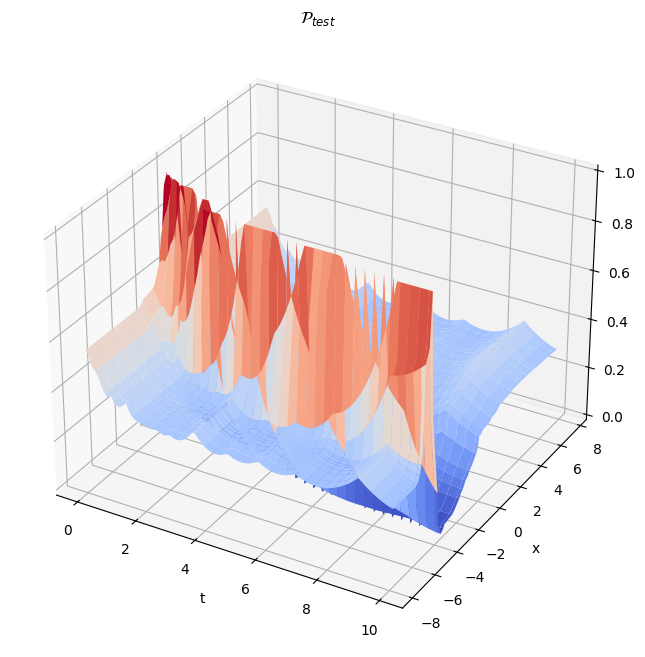

In [63]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
u_surf=ax.plot_surface(tt, xx, u_t_test, cmap=plt.cm.coolwarm)
plt.title("$\mathcal{P}_{test}$")
plt.xlabel('t')
plt.ylabel('x')

In [64]:
mean_squared_error(u_t_test, P_hat_test)

0.018648807545783942